In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import sys
import os
import string
import jax

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from stats import trials_until_correct, running_mean, performance

from jax import random, lax, nn
from jupyterthemes import jtplot
from pybefit.agents import HSMMAI as Agent

jtplot.style(theme='grade3', context='paper', fscale=1.6, grid=False)

%matplotlib inline

from opt_einsum import contract
def einsum(equation, *args):
    return contract(equation, *args, backend='jax')

In [3]:
from scipy import io
# load experiment and generate observations
data = io.loadmat('behavioral_data/main/states_and_rewards.mat')
Sirr = data['irregular']['S'][0, 0][:, 0] - 1
Oirr = data['irregular']['R'][0, 0]
Sreg = data['regular']['S'][0, 0][:, 0] - 1
Oreg = data['regular']['R'][0, 0]

runs = 50

outcomes1 = np.concatenate([(Oreg[:, None].repeat(runs, -2) + 1)//2, 
                            (Oirr[:, None].repeat(runs, -2) + 1)//2], -2)
outcomes2 = np.concatenate([Sreg[:, None].repeat(runs, -1) + 2, 
                             Sirr[:, None].repeat(runs, -1) + 2], -1)[..., None]

outcomes = jnp.concatenate([outcomes1, outcomes2], -1)

subs = jnp.array(range(2 * runs))
def process(t, responses):
    return outcomes[t, subs, responses]

In [4]:
# POMDP simulator
def simulator(process, agent, seed=0, **model_kw):
    def sim_fn(carry, t):
        rng_key, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = agent.action_selection(_rng_key, prior, **model_kw)
        
        outcomes = process(t, choices)
        
        posterior = agent.learning(t, outcomes, choices, prior)
                
        return (rng_key, posterior), {'choices': choices, 'beliefs': prior}
    
    rng_key = random.PRNGKey(seed)
    _, sequence = lax.scan(sim_fn, (rng_key, agent.prior), jnp.arange(len(outcomes)))
    sequence['choices'].block_until_ready()
    
    cpus = jax.devices("cpu")
    
    return jax.device_put(sequence, cpus[0])

In [5]:
def plot_trajectories(sequence, nu_range, label, rng_eodds=(.05, .1), ws=201):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey='row')
    trials = jnp.arange(101, 901)

    for nu in nu_range:
        states = outcomes[..., -1] - 2
        corr = (states == sequence[nu]['choices']).astype(jnp.float32)
        corr = jnp.where(sequence[nu]['choices'] == 2, jnp.nan, corr)
        expl = (sequence[nu]['choices'] == 2).astype(jnp.float32)
        rolling_prob = performance(expl, ws=ws)
        rolling_perf = performance(corr, ws=ws)
        
        for i in range(2):
            mean = rolling_perf[i:(i+1)*50].mean(0)
            std = rolling_perf[i:(i+1)*50].std(0, ddof=1)
            ci = 0.975 * std / jnp.sqrt(50)
            axes[0, i].plot(trials, mean, lw=3, label=label + r'{}'.format(nu), alpha=.8);
            axes[0, i].fill_between(trials, mean - ci, y2=mean + ci, alpha=.2)
            axes[0, i].vlines(800, 3, 12, color='gray', linestyle='--', lw=2)
            mean = rolling_prob[i:(i+1)*50].mean(0)
            std = rolling_prob[i:(i+1)*50].std(0)
            ci = 0.975 * std / jnp.sqrt(50)
            axes[-1, i].plot(trials, mean, lw=3, alpha=.8);
            axes[-1, i].fill_between(trials, mean - ci, y2=mean + ci, alpha=.1)
            axes[-1, i].vlines(800, rng_eodds[0], rng_eodds[1], color='gray', linestyle='--', lw=2)

    axes[0, 1].legend(loc=2, title='Model', fontsize=14);

    axes[0, 0].set_ylabel('Performance');
    axes[-1, 0].set_ylabel('Probing');

    axes[0, 0].set_title('Regular condition')
    axes[0, 1].set_title('Irregular condition')
    axes[-1, 0].set_xlabel('trial')
    axes[-1, 1].set_xlabel('trial')
    
    for i in range(2):
        axes[i, 0].text(-.075, 1., string.ascii_uppercase[i], transform=axes[i, 0].transAxes, size=20, weight='bold')

    fig.tight_layout()
    sns.despine(fig)

    return fig

In [6]:
T, N, _ = outcomes.shape
sequences1 = {}
for nu in [1, 3, 10]:
    agent = Agent(T, N, nu_max=nu, U=jnp.log(jnp.array([.1, .6, .3/2, .3/2])))
    sequences1[nu] = simulator(process, 
                               agent,
                               seed=10101, 
                               gamma=5)
    del agent

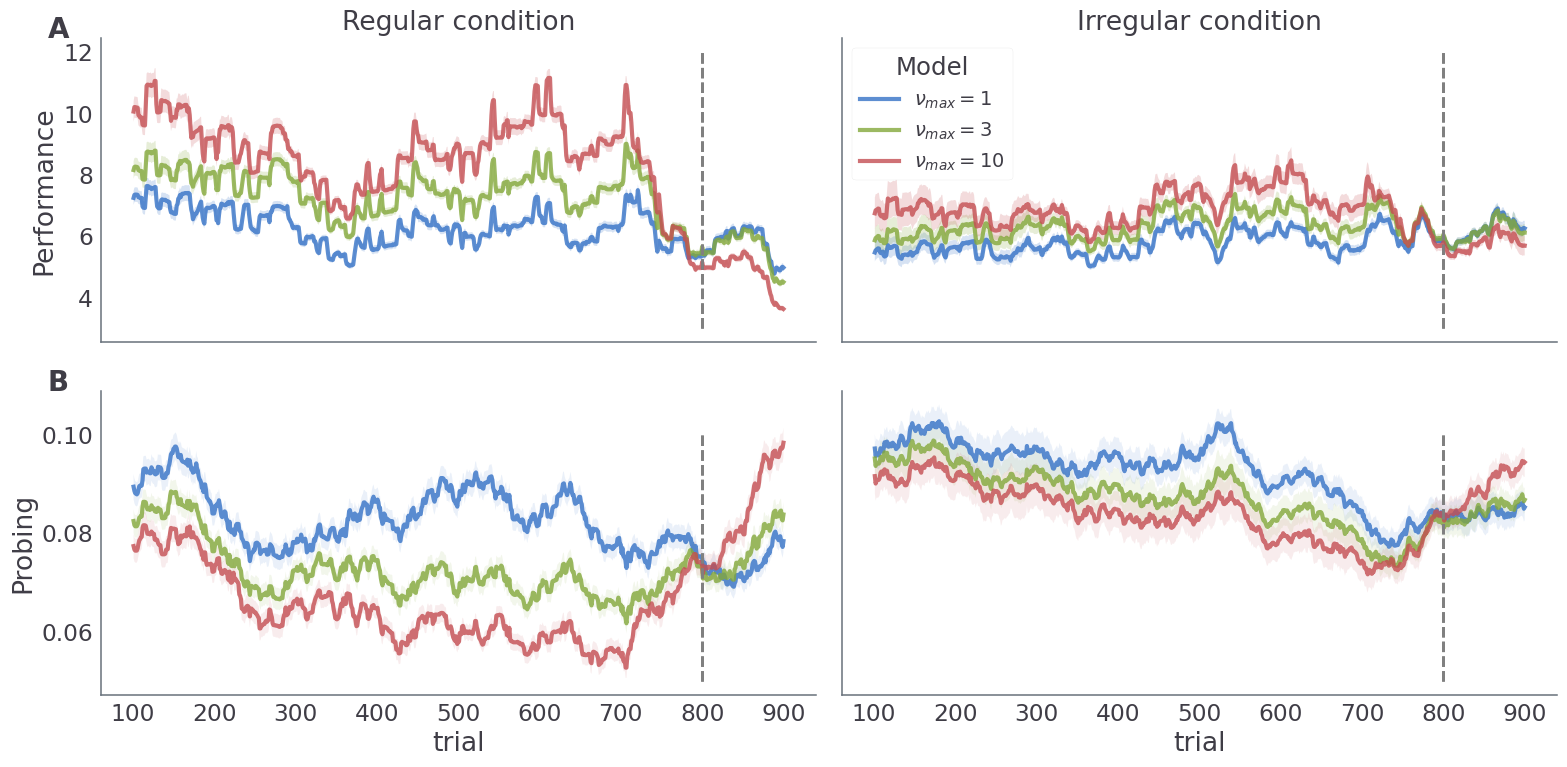

In [7]:
fig = plot_trajectories(sequences1, [1, 3, 10], r'$\nu_{max}=$')
fig.savefig('Fig5.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [8]:
T, N, _ = outcomes.shape
sequences2 = {}
for nu in [0, 2, 9]:
    agent = Agent(T, N, nu_max=10, nu_min=nu, U=jnp.log(jnp.array([.1, .6, .3/2, .3/2])))
    sequences2[nu] = simulator(process, 
                               agent,
                               seed=10101, 
                               gamma=5)
    del agent

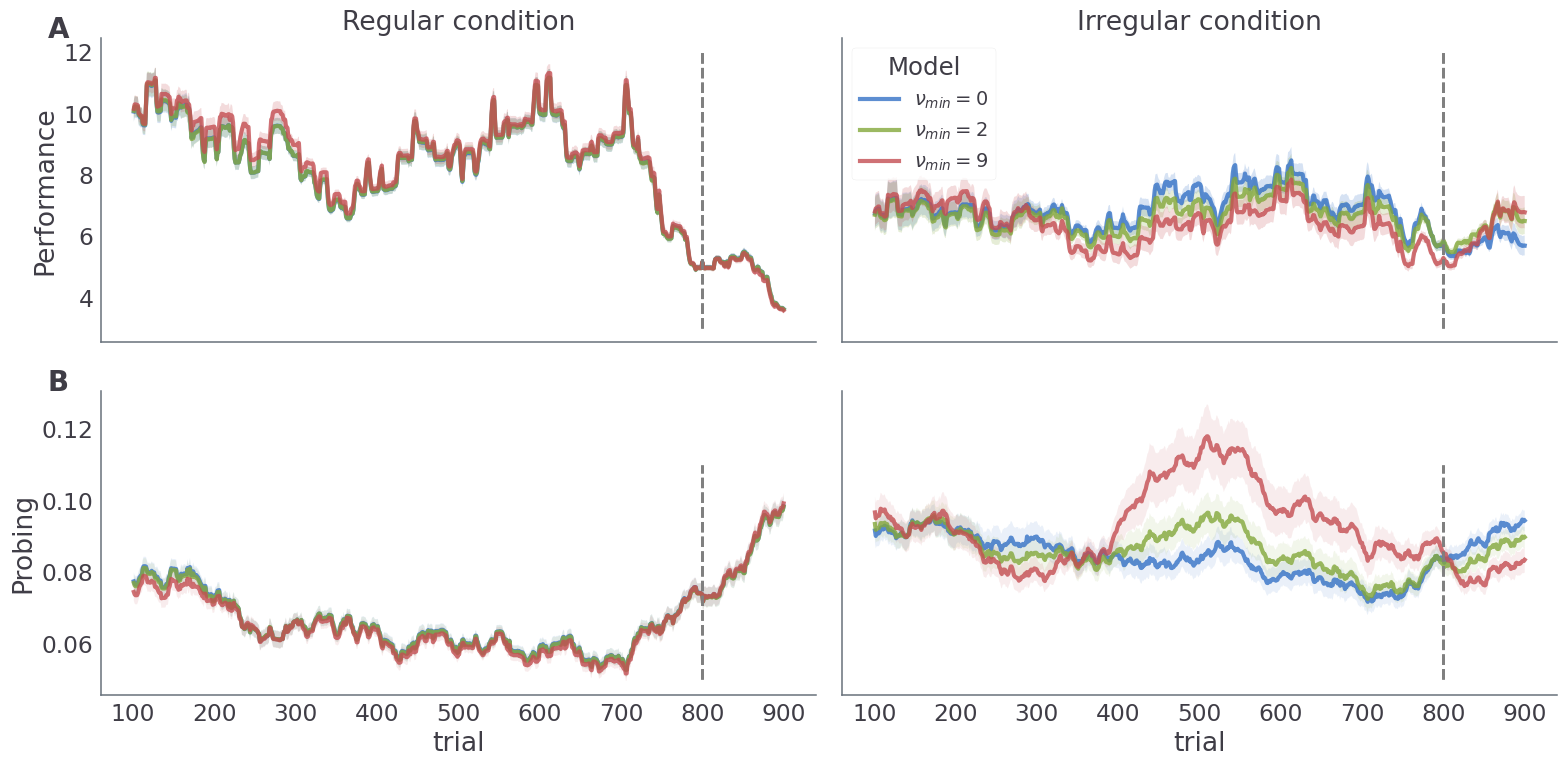

In [9]:
fig = plot_trajectories(sequences2, [0, 2, 9], r'$\nu_{min}=$', rng_eodds=(.05, .11))
# fig.savefig('supp_Fig5.pdf', bbox_inches='tight', transparent=True, dpi=300)

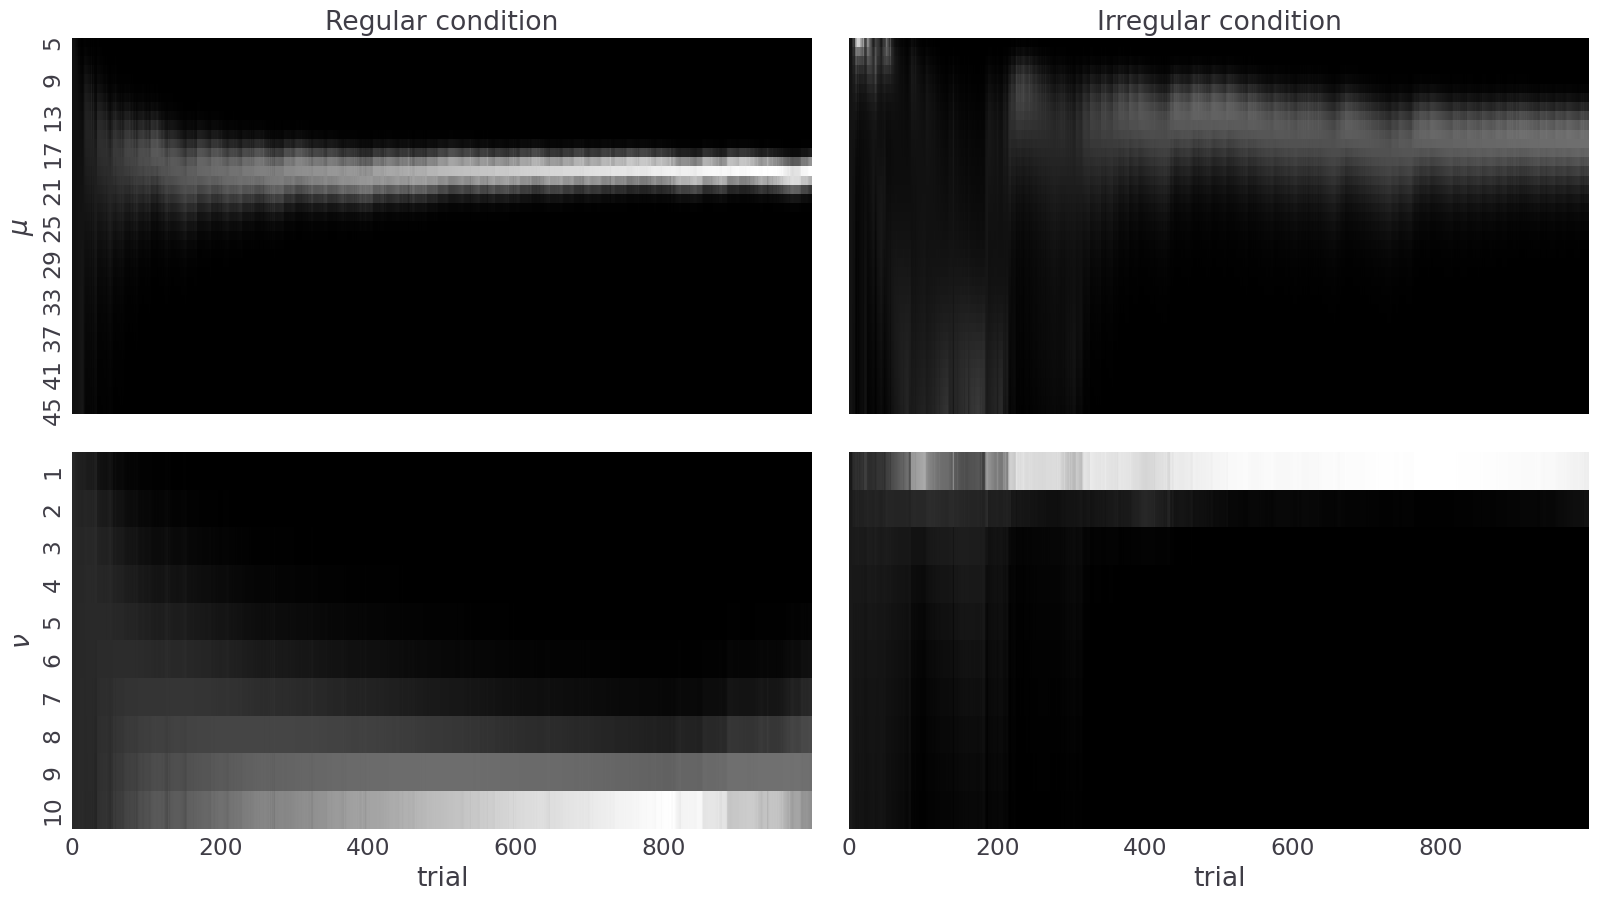

In [10]:
mu = jnp.arange(4, 45, 1)
nu = jnp.arange(1, 11, 1)
marg = einsum('...cfm->...m', sequences1[10]['beliefs'][0]).reshape(outcomes.shape[:-1] + (len(mu), len(nu)))

fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey='row')

for i, c in zip(range(2), [1, -1]):
    sns.heatmap(marg[:, c].sum(-1).T, ax=axes[0, i], cbar=False, cmap='gray')
    sns.heatmap(marg[:, c].sum(-2).T, ax=axes[1, i], cbar=False, cmap='gray')

fig.tight_layout()
axes[1, 0].set_xlabel('trial');
axes[1, 1].set_xlabel('trial');
axes[0, 0].set_ylabel(r'$\mu$');
axes[1, 0].set_ylabel(r'$\nu$');

axes[0, 0].set_yticklabels(mu.astype(int)[::4] + 1);
axes[1, 0].set_yticklabels(nu.astype(int));

trials = jnp.arange(0, marg.shape[0], 200);
axes[1, 0].set_xticks(trials);
axes[1, 0].set_xticklabels(trials, rotation=0);
axes[1, 1].set_xticklabels(trials, rotation=0);

axes[0, 0].set_title('Regular condition')
axes[0, 1].set_title('Irregular condition')

fig.savefig('Fig6.pdf', bbox_inches='tight', transparent=True, dpi=300)

Simulate behavioural measures for agents with varying $P_o^+$ and $P_o^-$.

In [ ]:
cpus = jax.devices("cpu")
T, N, _ = outcomes.shape
mus = jnp.arange(4., 45., 1.)
sequences_test = {}
for nu in [10]:
    dfs = []
    for P_p in [.5, .55, .6]:
        for P_m in np.arange(.05, .25 + .01, .01):
            P_o = jnp.array([P_m, P_p, (1 - P_p - P_m)/2, (1 - P_p - P_m)/2])
            P_o = (P_o + 1e-2)/(P_o + 1e-2).sum()
            agent = Agent(T, N, nu_max=nu, U=jnp.log(P_o))
            sequence = simulator(process, agent, seed=347432, gamma=5)

            states = jax.device_put(outcomes[..., -1] - 2, cpus[0])
            corr = (states == sequence['choices']).astype(jnp.float16)
            expl = sequence['choices'] == 2
            corr = jnp.nanmean(jnp.where(expl, jnp.nan, corr)[400:800], axis=0)
            perf = corr/(1 - corr)
            expl = jnp.clip(expl[400:800].mean(0), 1e-10, 1-1e-10)
            odds = expl/(1 - expl)
            
            marg = einsum('...cfm->...m', sequence['beliefs'][0]).reshape(outcomes.shape[:-1] + (-1, nu))[-200]
            rmse_mu = jnp.sqrt(jnp.sum(marg.sum(-1) * (mus - 19)**2, -1))
            
            rmse_nu = jnp.sum(marg[:runs].sum(-2) * (jnp.arange(1, nu+1) - 10)**2, -1)
            df = pd.DataFrame({'Performance': perf[:runs], 
                               'Probing': odds[:runs], 
                              r'$RMSE_{\mu}$': rmse_mu[:runs], 
                              r'$RMSE_{\nu}$': rmse_nu})
            df[r'$p_+$'] = float(f'{P_p:.2f}')
            df[r'$p_-$'] = P_m
            df['condition'] = 'Regular'
            dfs.append(df)
            
            rmse_nu = jnp.sum(marg[runs:].sum(-2) * (jnp.arange(1, nu + 1) - 1)**2, -1)
            df = pd.DataFrame({'Performance': perf[runs:], 
                               'Probing': odds[runs:], 
                               r'$RMSE_{\mu}$': rmse_mu[runs:], 
                               r'$RMSE_{\nu}$': rmse_nu})
            df[r'$p_+$'] = float(f'{P_p:.2f}')
            df[r'$p_-$'] = P_m
            df['condition'] = 'Irregular'
            dfs.append(df)
            
            del agent
    sequences_test[nu] = pd.concat(dfs, ignore_index=True)

In [ ]:
df1 = sequences_test[10].reset_index()
data1 = df1.loc[df1.condition == 'Irregular']
df2 = sequences_test[10].reset_index()
data2 = df2.loc[df2.condition == 'Regular']

data = pd.concat([data1, data2])
value_vars = ['Performance', r'$RMSE_{\mu}$', r'$RMSE_{\nu}$']
data_mlt= pd.melt(data, 
        id_vars=['condition', 'Probing', r'$p_+$', r'$p_-$'], 
        value_vars=value_vars)

g = sns.relplot(data=data_mlt, x=r'$p_-$', y='value', size='Probing', 
            col='condition', row='variable', hue=r'$p_+$',
            sizes=(50, 500), alpha=.2, aspect=2.4, palette="colorblind", 
            col_order=['Regular', 'Irregular'], 
            row_order=value_vars, facet_kws={'sharey': 'row'},).set_titles("{col_name} condition")

for i, label in enumerate(value_vars):
    g.axes[i, 0].set_ylabel(label)
    if i > 0:
        for j in range(2):
            g.axes[i, j].set_title(None)

g.savefig('Fig7.pdf', bbox_inches='tight', dpi=300)

In [ ]:
df1 = sequences_test[10].reset_index()
data1 = df1.loc[df1.condition == 'Irregular']
df2 = sequences_test[10].reset_index()
data2 = df2.loc[df2.condition == 'Regular']

data = pd.concat([data1, data2])
data[r'$p_c$'] = 1 - data[r'$p_+$'] - data[r'$p_-$']
value_vars = ['Performance', r'$RMSE_{\mu}$', r'$RMSE_{\nu}$']
data_mlt= pd.melt(data, 
        id_vars=['condition', 'Probing', r'$p_+$', r'$p_-$', r'$p_c$'], 
        value_vars=value_vars)

g = sns.relplot(data=data_mlt, x=r'$p_c$', y='value', size='Probing', 
            col='condition', row='variable', hue=r'$p_+$',
            sizes=(50, 500), alpha=.2, aspect=2.4, palette="colorblind", 
            col_order=['Regular', 'Irregular'], 
            row_order=value_vars, facet_kws={'sharey': 'row'},).set_titles("{col_name} condition")

for i, label in enumerate(value_vars):
    g.axes[i, 0].set_ylabel(label)
    if i > 0:
        for j in range(2):
            g.axes[i, j].set_title(None)
            
g.savefig('supp_Fig7.pdf', bbox_inches='tight', dpi=300)

In [ ]:
import numpy as np
from matplotlib import cm, colors

samples = np.load('results/fit_sims/sims_mcomp_P-0.1-0.6-0.15-0.15.npz', allow_pickle=True)['samples'].item()
M = 10
EP = np.stack([samples[i]['EP'] for i in range(1, M + 1)], 0)
weights = jax.nn.one_hot(EP.argmax(-1), M)

CM_reg = weights[:, :50].mean(-2)
CM_irr = weights[:, 50:].mean(-2)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey='row', sharex=True)
ticks = list(range(1, 11))

sns.heatmap(CM_reg, ax=axes[0], xticklabels=ticks, yticklabels=ticks, cbar=False, vmin=0, vmax=1, cmap='magma')
sns.heatmap(CM_irr, ax=axes[1], xticklabels=ticks, yticklabels=ticks, cbar=False, vmin=0, vmax=1, cmap='magma')

axes[0].set_ylabel(r'true $\nu_{max}$')
axes[0].set_xlabel(r'inferred $\nu_{max}$')
axes[1].set_xlabel(r'inferred $\nu_{max}$')
fig.tight_layout()

norm = colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'), ax=axes)
cbar.ax.set_ylabel('Probability', rotation=-90, labelpad=15);
axes[0].set_title('Regular condition');
axes[1].set_title('Irregular condition');

fig.savefig('sup_Fig8.pdf', bbox_inches='tight', dpi=300)

In [ ]:
from pycm import *
n = EP.argmax(-1).shape[-1]//2

y_pred_reg = EP[:, :n].argmax(-1).flatten()
y_true = np.stack([ i*jnp.ones(n, dtype=np.int32) for i in range(M) ], 0).flatten()
cm_reg = ConfusionMatrix(actual_vector=y_true > 0, predict_vector=np.array(y_pred_reg) > 0)

y_pred_irr = EP[:, n:].argmax(-1).flatten()
y_true = np.stack([ i*jnp.ones(n, dtype=np.int32) for i in range(M) ], 0).flatten()
cm_irr = ConfusionMatrix(actual_vector=y_true > 0, predict_vector=np.array(y_pred_irr) > 0)

In [ ]:
print(cm_reg.matrix)
cm_reg.overall_stat

In [ ]:
print(cm_irr.matrix)
cm_irr.overall_stat